# Model Tuning and Testing
This notebook contains the code for and documentation of the final stages of this machine learning task. These include:
1. Importing the input, target and info data from csv files.
2. Reformatting and normalising the input data.
3. Parameter tuning through multiple iterations of nested cross-validation.
4. Accuracy test on unseen examples from patches otherwise present in the dataset.
5. Accuracy test on unseen patches for models trained on all other patches.

In [148]:
## ======== libraries ======== ##


# mathematical operations
import numpy as np

# obtains principal componenets and projects new data
from sklearn.decomposition import PCA

# Multilayer perceptron for classifcation
from sklearn.neural_network import MLPClassifier

# to import data from csvs
import csv

# plotting results
import matplotlib.pyplot as plt

In [234]:
## ======== function definitions ======== ##


# extracts a list of sublists from a csv file
def read_csv(path, convert_to_float = False):

    data = []
    
    my_file = open(path)

    readCSV = csv.reader(my_file, delimiter=',')
    
    for row in readCSV:
        
        # if True strings are converted to floating points
        # necessary as floats written to csv files become strings
        if(convert_to_float):
            
            row = [float(element) for element in row]
            
        data.append(row)
                        
    return data
    

# divides each sublist into multiple lists of a given length
# necessary as 2d lists of mfccs were flattened to be written to csv
def unflatten_sublists(data, length):
    
    unflattened_data = []
    
    for example in data:
        
        # divides long list in to smaller ones and stores as a 2d list
        unflattened_example = [example[i:i+length] for i in range(0, len(example), length)]
        
        unflattened_data.append(unflattened_example)
    
    return unflattened_data
    
    
# normalizes values per sample across each mfcc
def normalize_data(x):
    
    # returns matrix of zeros in the same shape as input data
    data = zeros(shape(x))

    # loops through each mfcc
    for i in range(len(x[0])):
        
        # gathers the same sample across each mfcc
        feature = [example[i] for example in x]
        
        max_val = np.max(feature)
        
        min_val = np.min(feature)
        
        # max and min values allow us to calculate the range of values
        val_range = max_val - min_val
        
        for j in range(len(x)):
        
            # by subtracting the min and dividing by the range we normalise each value
            data[j][i] = (x[j][i] - min_val) / val_range
            
    return data


# reduces dimensionality of data using principal componenet analysis
def reduce_dimensions(data, n_components):
    
    # a dimension is reduced to size n_components
    pca = PCA(n_components=n_components)
    
    # first the principal components are calculated
    pca.fit(data)
    
    # then data is projected to calculate new values
    reduced_data = pca.transform(data)
    
    return reduced_data


# prepare data for training: trim n_mfccs, perform pca, flatten
def prepare_input(n_mfccs, n_components, norm_mfccs):
    
    X = []

    for example in norm_mfccs:
    
        # reduce number of mfccs, starting with higher mfccs first
        trimmed_mfccs = example[:n_mfccs]
    
        reduced_mfccs = reduce_dimensions(trimmed_mfccs, n_components)
        
        # arrays flattened to single dimension as our MLP takes input in this format
        flattened = [item for sublist in reduced_mfccs for item in sublist]
    
        X.append(flattened)
    
    return X


# compares predicted and true classes and returns accuracy as a percentage
def accuracy_score(pred, true):
    
    correct = np.sum(pred==true)
    
    accuracy = correct/len(pred)
    
    return accuracy


# computes confusion matrix from predicted and true classes
def confusion_matrix(pred, true, n_classes):
    
    # matrix of zeros created with both dimensions equal to number of classes in dataset
    matrix = np.zeros([n_classes, n_classes], dtype = int)
    
    # each pair of predicted and true values increase their corresponding matrix position by 1
    for i in range(len(pred)): matrix[pred[i]][true[i]] += 1
    
    return matrix


# splits indices between training, testing and validation folds for nested cross-val.
# split is determined by the current outer fold i.
def assign_bins(fold_k, i, bins):
    
    fold_test = []
    
    fold_val = []
    
    fold_train = []
    
    # each bins is assigned to a fold corresponding to the rule:
    # bin[i] -> test, bin[i+1] -> validation, rest -> train
    for j in range(0,len(bins)):
            
            if(j == i):
                
                fold_test.extend(bins[j])
                
            elif(j == i + 1):
                
                fold_val.extend(bins[j])
                
            elif((j == 0) & (i == fold_k - 1)):
                
                fold_val.extend(bins[j])
                
            else:
                
                fold_train.extend(bins[j])
    
    return fold_train, fold_test, fold_val


# nested cross validation performs parameter tuning and assesses the performance of models on unseen data.
# this is an altered version of one submitted as part of coursework for my machine learning module
def nested_cross_val(norm_mfccs, y, fold_k, n_components, n_hiddens, activations, my_seed):

    # final accuracy on test data will be saved across each of the k folds
    accuracy_fold=[]
    
    np.random.seed(my_seed)
    
    # indices referring to each data point are created and their position randomised
    indices = np.random.permutation(len(norm_mfccs))
    
    # these indices are then split in to k bins
    bins = np.array_split(indices, fold_k)
    
    # each configuration of folds is looped through
    for i in range(0,fold_k):
        
        fold_train, fold_test, fold_val = assign_bins(fold_k, i, bins)
        
        best_accuracy = - 1000
        
        # each configuration of folds is tested on each combination of parameters
        for j in range(0, len(n_components)):
            
            # data is trimemd to correct numer of mfccs and dimensions reduced to correct numer of components
            X = np.asarray(prepare_input(20, n_components[j], norm_mfccs))
            
            for k in range(0, len(n_hiddens)):
                
                for l in range(0, len(activations)):
    
                    # network initiated with correct parameters and then fitted before predictions are made
                    net = MLPClassifier(activation=activations[l], hidden_layer_sizes=([n_hiddens[k]]), learning_rate_init=0.01)

                    net.fit(X[fold_train], y[fold_train])

                    preds = net.predict(X[fold_val])
                
                    temp_accuracy = (accuracy_score(preds, y[fold_val]))
                    
                    print'~~ fold: ' + str(i) + ' n_comps: ' + str(n_components[j]) + ' n_hids: ' + str(n_hiddens[k]) + ' activ: ' + str(activations[l]) + ' acc: ' + str(temp_accuracy)
                    
                    # if the accuracy for current paramters is best all paramters are saved as best for fold
                    if(temp_accuracy > best_accuracy):
                        
                        best_components = n_components[j] 
                        
                        best_hiddens = n_hiddens[k]
                        
                        best_activation = activations[l]
                        
                        best_accuracy = temp_accuracy
        
        print '**** End of val for this fold, best n_comps: '+ str(best_components) + ' best n_hids: ' + str(best_hiddens) + ' best_activ: ' + str(best_activation) + ' best acc: ' + str(best_accuracy)

        # training fold is extended to include the validation fold to give model maximum training data
        fold_train.extend(fold_val)
        
        # fitting and prediction are carried out as before but with best parameters for the fold
        X = np.asarray(prepare_input(20, best_components, norm_mfccs))

        net = MLPClassifier(activation=best_activation, hidden_layer_sizes=([best_hiddens]), learning_rate_init=0.01)

        net.fit(X[fold_train], y[fold_train])

        preds = net.predict(X[fold_test])
                
        temp_accuracy = (accuracy_score(preds, y[fold_test]))
        
        print 'test set accuracy: ' + str(temp_accuracy)
        
        print 'test set confusion Matrix:'
        
        print(confusion_matrix(preds, y[fold_test], 3))
        
        accuracy_fold.extend([temp_accuracy])

    return accuracy_fold;


# stores all indices for misclassified examples to be used for analysys
def failed_indices(preds, y, fold_test):
    
    indices = []
    
    for i in range(len(preds)):
        
        if(preds[i] != y[fold_test[i]]):
            
            indices.append(fold_test[i])
    
    return indices


# plots the frequency with which examples played at each note were misclassified
def plot_note_counts(note_counts):
    
    # trim count to start with the first note at which a misclassification is counted
    for i in range(len(note_count)):
        
        if(note_count[i] != 0):
            
            minimum = i
            
            break
    
    trimmed_note_counts = note_counts[minimum:]

    plt.bar(np.arange(minimum, 109), trimmed_note_counts)
    
    plt.title("Midi Notes of Incorrectly Classified Examples")
    
    plt.xlabel("Midi Notes")
    
    plt.ylabel("Frequency")
    

# split the indices in to bins by unique patch rather than randomly
def bins_by_patch(y, patch_index):
    
    bins = []
    
    # examples were labeled with a class index and a patch index beteween 0 and 7. each class had 
    # 7 unique patches within it. to seperate each unique patch within the data set it was 
    # necessary to check for indices that were present when the list of target classes and patch 
    # indexes were searched for each combination of class index and patch index.
    # sorry dont know how to explain that any better!
    for i in range(len(np.unique(y))):
        
        for j in range(len(np.unique(patch_index))):
            
            matches = []
                        
            group1 = np.argwhere(patch_index == j)
            
            group2 = np.argwhere(y == i)
            
            for item1 in group1:
                
                for item2 in group2:
                    
                    if item1 == item2:
                        
                        matches.extend(list(item1))
                        
            bins.append(matches)
            
    return bins

### Importing and Normalising Data
As our MFCC and info data was saved to csv files in the 'feature_extraction' notebook it is now necessary to import and unpack it. 

To save the 20 X 173 array of MFCC's for each example to a csv we had to reshape them into single dimensional lists, this must be undone. We will then perform the first step of pre-processing the data by normalising the MFCC's.

From our info array we will unpack each feature into its own list. In order these are: y (target class), patch_index (the index of the patch within each class) and note (the midi note played for that example).

In [8]:
## ======== importing and normalising data ======== ##


mfcc_path = "/users/angelorussell/Desktop/monopoly_data/mfccs.csv"

# 173 samples were taken from each MFCC so to reshape our array we need this value
length = 173

flattened_mfccs = read_csv(mfcc_path, convert_to_float = True)

mfccs = unflatten_sublists(flattened_mfccs, length)

print "*** mfccs imported and unflattened ***"

norm_mfccs = []

# normalize_data function takes two dimensional arrays so we pass it one example at a time
for example in mfccs:
    
    norm = normalize_data(example)
    
    norm_mfccs.append(norm)
    
print "*** mfccs normalised ***"

info_path = "/users/angelorussell/Desktop/monopoly_data/info.csv"

info = read_csv(info_path)

# first element of each sublist is the target class
y = np.asarray([int(element[0]) for element in info])

# the second is the patch index
patch_index = np.asarray([int(element[1]) for element in info])

# third is the MIDI note
note = np.asarray([int(element[2]) for element in info])

print "*** info and targets imported ***"

*** mfccs imported and unflattened ***
*** mfccs normalised ***
*** info and targets imported ***


### Nested Cross-Validation

Once our data is imported and formatted we begin tuning the hyperparamters our model. This means that we will attempt to find their configuration at which our model performs best on unseen data. 

We will be working with a Multi-Layer Perceptron with a single layer of hidden neurons which has a large number hyperparameters including: learning rate, activation function and number of hidden neurons. Simaltaneously we will be attempting to find the number of principal componenets extracted from our MFCCs at which our model performs best.

From examing the final test accuracies we will also be able to assess how well our model will generalise to unseen data. From this variance in this accuracy we will also be able to tell how conisitent the model is.

In [233]:
## ======== nested cross validation ======== ##


my_seed = 1234

# the next three lines contain all the parameters for our nested cross-validation to test on
n_components = [1, 2, 3, 4]

n_hiddens = np.arange(20, 101, 20)

activations = ['logistic', 'tanh', 'relu']

fold_k = 5

# this function will print a running feed of its results and will return a final array of test accuracies
accuracies = nested_cross_val(norm_mfccs, y, fold_k, n_components, n_hiddens, activations, my_seed)

print 'test accuracies:' + str(accuracies)

~~ fold: 0 n_comps: 1 n_hids: 20 activ: logistic acc: 0.789915966387
~~ fold: 0 n_comps: 1 n_hids: 20 activ: tanh acc: 0.795518207283
~~ fold: 0 n_comps: 1 n_hids: 20 activ: relu acc: 0.686274509804
~~ fold: 0 n_comps: 1 n_hids: 40 activ: logistic acc: 0.809523809524
~~ fold: 0 n_comps: 1 n_hids: 40 activ: tanh acc: 0.826330532213
~~ fold: 0 n_comps: 1 n_hids: 40 activ: relu acc: 0.789915966387
~~ fold: 0 n_comps: 1 n_hids: 60 activ: logistic acc: 0.843137254902
~~ fold: 0 n_comps: 1 n_hids: 60 activ: tanh acc: 0.817927170868
~~ fold: 0 n_comps: 1 n_hids: 60 activ: relu acc: 0.789915966387
~~ fold: 0 n_comps: 1 n_hids: 80 activ: logistic acc: 0.84593837535
~~ fold: 0 n_comps: 1 n_hids: 80 activ: tanh acc: 0.840336134454
~~ fold: 0 n_comps: 1 n_hids: 80 activ: relu acc: 0.837535014006
~~ fold: 0 n_comps: 1 n_hids: 100 activ: logistic acc: 0.736694677871
~~ fold: 0 n_comps: 1 n_hids: 100 activ: tanh acc: 0.817927170868
~~ fold: 0 n_comps: 1 n_hids: 100 activ: relu acc: 0.809523809524
~~ 

test set accuracy: 0.943977591036
test set confusion Matrix:
[[107   4   3]
 [  4 110   1]
 [  8   0 120]]
~~ fold: 2 n_comps: 1 n_hids: 20 activ: logistic acc: 0.837535014006
~~ fold: 2 n_comps: 1 n_hids: 20 activ: tanh acc: 0.703081232493
~~ fold: 2 n_comps: 1 n_hids: 20 activ: relu acc: 0.711484593838
~~ fold: 2 n_comps: 1 n_hids: 40 activ: logistic acc: 0.823529411765
~~ fold: 2 n_comps: 1 n_hids: 40 activ: tanh acc: 0.812324929972
~~ fold: 2 n_comps: 1 n_hids: 40 activ: relu acc: 0.759103641457
~~ fold: 2 n_comps: 1 n_hids: 60 activ: logistic acc: 0.795518207283
~~ fold: 2 n_comps: 1 n_hids: 60 activ: tanh acc: 0.806722689076
~~ fold: 2 n_comps: 1 n_hids: 60 activ: relu acc: 0.756302521008
~~ fold: 2 n_comps: 1 n_hids: 80 activ: logistic acc: 0.803921568627
~~ fold: 2 n_comps: 1 n_hids: 80 activ: tanh acc: 0.834733893557
~~ fold: 2 n_comps: 1 n_hids: 80 activ: relu acc: 0.829131652661
~~ fold: 2 n_comps: 1 n_hids: 100 activ: logistic acc: 0.823529411765
~~ fold: 2 n_comps: 1 n_hid

~~ fold: 3 n_comps: 4 n_hids: 100 activ: relu acc: 0.859943977591
**** End of val for this fold, best n_comps: 2 best n_hids: 40 best_activ: tanh best acc: 0.929971988796
test set accuracy: 0.915966386555
test set confusion Matrix:
[[ 94   4   7]
 [  1 120   2]
 [ 11   5 113]]
~~ fold: 4 n_comps: 1 n_hids: 20 activ: logistic acc: 0.719887955182
~~ fold: 4 n_comps: 1 n_hids: 20 activ: tanh acc: 0.72268907563
~~ fold: 4 n_comps: 1 n_hids: 20 activ: relu acc: 0.725490196078
~~ fold: 4 n_comps: 1 n_hids: 40 activ: logistic acc: 0.798319327731
~~ fold: 4 n_comps: 1 n_hids: 40 activ: tanh acc: 0.812324929972
~~ fold: 4 n_comps: 1 n_hids: 40 activ: relu acc: 0.739495798319
~~ fold: 4 n_comps: 1 n_hids: 60 activ: logistic acc: 0.677871148459
~~ fold: 4 n_comps: 1 n_hids: 60 activ: tanh acc: 0.806722689076
~~ fold: 4 n_comps: 1 n_hids: 60 activ: relu acc: 0.72268907563
~~ fold: 4 n_comps: 1 n_hids: 80 activ: logistic acc: 0.834733893557
~~ fold: 4 n_comps: 1 n_hids: 80 activ: tanh acc: 0.753501

### Analysing Results of Nested Cross-Validation

First we will discuss the parameters that achieved the highest accuracies. 

Across all five folds the optimum number of componenets for PCA was deemed to be 2. This was the only parameter to receuve the same best choice across all folds. The next most unanimous decision was for activation function, which for four out of five folds was chosen to be tanh. The logistic function also performed well on the second fold however the results clearly point to using tanh. In terms of number of hidden nodes there was still a clear best choice with 100 performing the best across 3 of five folds.

In terms of our test fold accuracies, results were very promising. All folds achived over 91% accuracy and there was very little variance with the highest accuracy being 94.4%. This not only means has the capacity to be very accuracte but that it is also consistent.

### Initial Accuracy Test

We will now test our model using the best parameter from cross validation; 2 components, tanh activation function and 100 hidden neurons. It's accuracy when tested on unseen examples from patches otherwise present in the data will be averaged over 100 folds. We will also compute a confusion matrix and visualise how examples at different MIDI notes perform.

average accuracy over 100 iterations: 0.9568
total confusion matrix: 
[[3212  119   74]
 [  83 3281   37]
 [ 100   19 3075]]


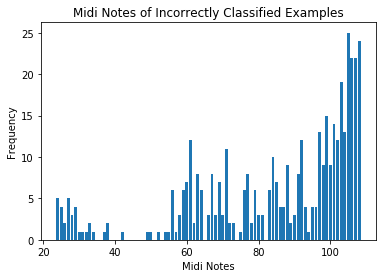

In [153]:
## ======== accuracy test ======== ##

accuracies = []

# the example indices for all failed classification will be stored here
failed = []

n_components = 2

n_hiddens = 100

X = np.asarray(prepare_input(20, n_components, norm_mfccs))

# an empty matrix is created to store the total confusion matrix after all iterations
total_matrix = np.zeros([3, 3], dtype = int)

# this process will be iterated 100 times to gain a reliable estimate for the models accuracy
for i in range(100):

    indices = np.random.permutation(len(X))
    
    # this training and test split 100 random examples for testing and the rest for training
    fold_train, fold_test = indices[100:], indices[:100]
    
    net = MLPClassifier(activation='tanh', hidden_layer_sizes=([n_hiddens]), learning_rate_init=0.01)

    net.fit(X[fold_train], y[fold_train])

    preds = net.predict(X[fold_test])
                
    accuracies.extend([accuracy_score(preds, y[fold_test])])
    
    failed.extend(np.asarray(failed_indices(preds, y, fold_test)))
    
    total_matrix += confusion_matrix(preds, y[fold_test])
    
print 'average accuracy over 100 iterations: ' + str(np.sum(accuracies) / 100)

print 'total confusion matrix: ' + '\n' + str(total_matrix)

# an array containing the count of examples misclassified at each MIDI note is returned
# the index of the element refers to the note and the count is the value of the element
note_counts = np.bincount(note[failed])

# this count is then plotted
plot_note_counts(note_counts)

### Secondary Accuracy Test
Upon reflection I realised that the initial accuracy test reflected the models ability to recognise the properties of individual patches rather than their patch type. To truly test whether the model will generalize to unseen patches we must instead split our examples into bins by their individual patches.

average accuracy for unseen patches: 0.620168067227
total confusion matrix: 
[[306 175 122]
 [157 370  42]
 [132  50 431]]


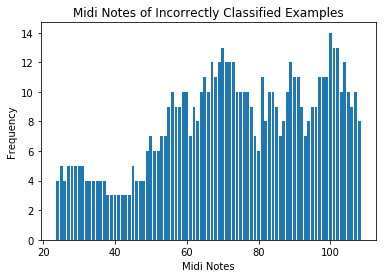

In [229]:
## ======== accuracy test for unseen patch ======== ##


n_components = 2

n_hiddens = 100

accuracies = []

failed = []

n_classes = 3

total_matrix = np.zeros([3, 3], dtype = int)

X = np.asarray(prepare_input(20, n_components, norm_mfccs))

# the only significant difference between these tests is that our bins are seperated by patch.
bins = bins_by_patch(y, patch_index)

for i in range(len(bins)):
    
    fold_test = bins[i]
    
    fold_test = reshape(fold_test, -1)
    
    fold_train = bins[:i]
    
    fold_train.extend(bins[i+1:])
    
    fold_train = reshape(fold_train, -1)
    
    net = MLPClassifier(activation='tanh', hidden_layer_sizes=([n_hiddens]), learning_rate_init=0.01)

    net.fit(X[fold_train], y[fold_train])

    preds = net.predict(X[fold_test])
                    
    accuracies.extend([accuracy_score(preds, y[fold_test])])
    
    failed.extend(np.asarray(failed_indices(preds, y, fold_test)))
    
    total_matrix += confusion_matrix(preds, y[fold_test], n_classes)
    
print 'average accuracy for unseen patches: ' + str(np.sum(accuracies) / len(bins))

print 'total confusion matrix: ' + '\n' + str(total_matrix)

note_counts = np.bincount(note[failed])

plot_note_counts(note_counts)

## Full analysis of the results from both tests are present in my report.